In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import h5py

from tqdm import tqdm
from scipy.signal import savgol_filter

import sys
sys.path.append('../')
from tracker import loadAntData, pltsaveall

From tracker/_init__.py:
SLEAP not detected; make sure to install SLEAP if intending to use postprocessing notebook. Otherwise, ignore this message.


## Load data

In [2]:
dataFile = '/home/jack/Workspaces/data/ant_tracking/ant_dataset_1_2026-02-01.h5'

# This variable doesn't matter here since we don't exclude short segments
# for computing occupation maps.
minimumLength = 15 # seconds
smoothingWindow = 10 # frames
maximumTimeSkip = 10 # frames

excludeOutliers = True
excludeShortSegments = False
excludeObjects = True

padding = None # mm
inversePadding = None # mm

dataArr, timeArr, metadataArr = loadAntData(dataFile, minimumLength=minimumLength,
                                            smoothingWindow=smoothingWindow, maximumTimeSkip=maximumTimeSkip,
                                            excludeOutliers=excludeOutliers, excludeShortSegments=excludeShortSegments,
                                            excludeObjects=excludeObjects,
                                            borderPadding=padding, inverseBorderPadding=inversePadding,
                                            debug=True)

Loading SLEAP data: 100%|██████████████████| 1434/1434 [00:01<00:00, 813.37it/s]


Loaded 1254 segments!


In [4]:
padding = 15 # mm
inversePadding = None

noWallDataArr, noWallTimeArr, noWallMetadataArr = loadAntData(dataFile, minimumLength=minimumLength,
                                                            smoothingWindow=smoothingWindow, maximumTimeSkip=maximumTimeSkip,
                                                            excludeOutliers=excludeOutliers, excludeShortSegments=excludeShortSegments,
                                                            excludeObjects=excludeObjects,
                                                            borderPadding=padding, inverseBorderPadding=inversePadding,
                                                            debug=True)

Removing trajectories near walls: 100%|█████| 1276/1276 [01:07<00:00, 18.99it/s]

Loaded 2625 segments!


# Combined occupation and phase space map

I tried to combine the information from the phase space and occupation maps into a single figure, but couldn't get it to work well.

In [6]:
# Compute the orientation of the walker
def computeOrientation(trajectoryArr):
    """
    """
    # We will need the step sizes (in the measured frame)
    # to weight the contributions to the overall run direction
    originalStepDirectionArr = trajectoryArr[1:] - trajectoryArr[:-1]
   
    # Compute the orientation (angle) of the walker at each step.
    absoluteAngleArr = np.arctan2(*(originalStepDirectionArr.T / np.sqrt(np.sum(originalStepDirectionArr**2, axis=-1))))

    # This will have length one less than trajectory arr, so we duplicate the value at the beginning
    # so it can be indexed the same.
    absoluteAngleArr = np.concatenate((absoluteAngleArr[:1], absoluteAngleArr))

    if len(absoluteAngleArr) > 5:
        # Smooth gently
        absoluteAngleArr = savgol_filter(absoluteAngleArr, 5, 1)
    
    return absoluteAngleArr

In [8]:
numSpatialBins = 50
numAngleBins = 20

# Compute the edges of the arena from the trajectories
# (accounting for padding if we have any).
minDataPoints = np.min([np.min(d, axis=0) for d in dataArr if len(d) > 1], axis=0)
maxDataPoints = np.max([np.max(d, axis=0) for d in dataArr if len(d) > 1], axis=0)

scalingFactor = (maxDataPoints - minDataPoints)
scalingFactor /= np.max(scalingFactor)

xBins = np.linspace(minDataPoints[0], maxDataPoints[0], int(scalingFactor[0]*numSpatialBins+1))
yBins = np.linspace(minDataPoints[1], maxDataPoints[1], int(scalingFactor[1]*numSpatialBins+1))
#angleBins = np.linspace(-np.pi, np.pi, numAngleBins+1)
angleBins = np.linspace(-np.pi * (1 + 1/numAngleBins), np.pi * (1 - 1/numAngleBins), numAngleBins+1)

# The midpoints of the bins that we will use to plot
xBinArr = (xBins[1:] + xBins[:-1]) / 2
yBinArr = (yBins[1:] + yBins[:-1]) / 2
angleBinArr = (angleBins[1:] + angleBins[:-1]) / 2

uniqueTrials = np.unique([m["name"] for m in metadataArr])

occupationMapArr = np.zeros((len(uniqueTrials),
                             int(scalingFactor[0]*numSpatialBins),
                             int(scalingFactor[1]*numSpatialBins)))

phaseSpaceMapArr = np.zeros((len(uniqueTrials),
                             int(scalingFactor[0]*numSpatialBins),
                             int(scalingFactor[1]*numSpatialBins),
                             numAngleBins))

indexDict = dict(zip(uniqueTrials, np.arange(len(uniqueTrials))))

for i in tqdm(range(len(dataArr))):
    if len(dataArr[i]) <= 1:
        continue
        
    angles = computeOrientation(dataArr[i])
    parameterSpaceArr = np.zeros((len(dataArr[i]), 3))
    parameterSpaceArr[:,:2] = dataArr[i]
    parameterSpaceArr[:,-1] = angles
    
    hist, bins = np.histogramdd(parameterSpaceArr, bins=[xBins, yBins, angleBins])
    phaseSpaceMapArr[indexDict[metadataArr[i]["name"]]] += hist / metadataArr[i]["fps"]

    hist, x, y = np.histogram2d(*dataArr[i].T, bins=[xBins, yBins])
    occupationMapArr[indexDict[metadataArr[i]["name"]]] += hist / metadataArr[i]["fps"]


  2%|▊                                       | 28/1311 [00:00<00:09, 136.79it/s]/tmp/ipykernel_381173/2625513920.py:10: RuntimeWarning: invalid value encountered in divide
  absoluteAngleArr = np.arctan2(*(originalStepDirectionArr.T / np.sqrt(np.sum(originalStepDirectionArr**2, axis=-1))))
100%|█████████████████████████████████████| 1311/1311 [00:01<00:00, 1123.11it/s]


/tmp/ipykernel_381173/1485933894.py:32: RuntimeWarning: invalid value encountered in power
  alphaArr = np.array(alphaNorm(totalOccupationMapArr))**1.05


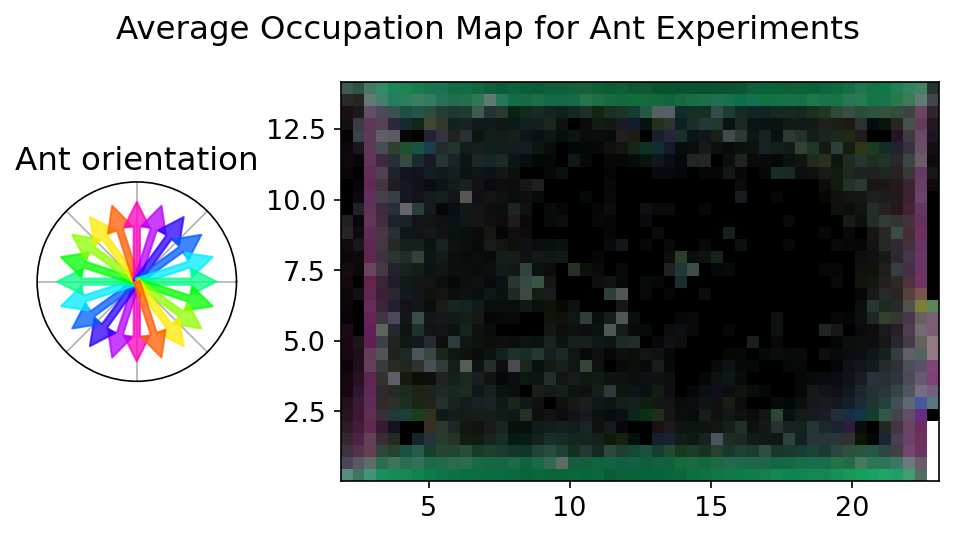

In [165]:
testAngleIndices = [10, 5]

colormap = plt.get_cmap('gist_rainbow_r')
norm = mpl.colors.Normalize(vmin=0, vmax=np.pi)
angleColorArr = colormap(norm((angleBinArr + np.pi) % np.pi))

fig = plt.figure()
gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[1,3])

radialAx = fig.add_subplot(gs[0], projection='polar')
ax = fig.add_subplot(gs[1])
fig.subplots_adjust(bottom=0.30)

# Compute the color for each point
totalOccupationMapArr = np.mean(occupationMapArr, axis=0)
totalPhaseSpaceMapArr = np.mean(phaseSpaceMapArr, axis=0)

pcolorArr = np.ones((occupationMapArr.shape[1], occupationMapArr.shape[2], 4))
for i in range(pcolorArr.shape[0]):
    for j in range(pcolorArr.shape[1]):
        if np.sum(totalPhaseSpaceMapArr[i,j]) == 0:
            continue
            
        pcolorArr[i,j] = np.average(angleColorArr, weights=totalPhaseSpaceMapArr[i,j], axis=0)

pcolorArr = np.swapaxes(pcolorArr, 0, 1)

# Set the alpha channel using the overall occupation
alphaNorm = mpl.colors.LogNorm(vmin=np.nanmin(totalOccupationMapArr) + 1e-1,
                               vmax=np.nanmax(totalOccupationMapArr))

alphaArr = np.array(alphaNorm(totalOccupationMapArr))**1.05
#alphaArr[alphaArr < -5] = np.nan
alphaArr -= np.nanmin(alphaArr)
alphaArr = (alphaArr + 0.05) / np.nanmax(alphaArr + 0.05)

alphaArr[np.isnan(alphaArr)] = 0

#alphaArr[:] = 1
pcolorArr[:,:,-1] = alphaArr.T

#pcolorArr = (pcolorArr[:,:,:3].T * alphaArr).T

# pcolormesh can only take a single alpha value for the whole
# mesh, so we have to manually construct the image from rectangular patches
ax.pcolormesh(xBinArr/10, yBinArr/10, np.zeros_like(pcolorArr[:,:,:3]))

for i in range(pcolorArr.shape[0]):
    for j in range(pcolorArr.shape[1]):
        rect = mpl.patches.Rectangle((xBins[j]/10, yBins[i]/10), xBins[j + 1]/10 - xBins[j]/10, yBins[i + 1]/10 - yBins[i]/10,
                                     facecolor=pcolorArr[i,j,:3], alpha=pcolorArr[i,j,-1], edgecolor='none')
        ax.add_patch(rect)

ax.set_aspect(1)
ax.relim()
ax.autoscale(enable=True, tight=True)

for i in range(len(angleBinArr)):
    
    #radialAx.arrow(0, 0, np.cos(angleBinArr[angleIndex]), np.sin(angleBinArr[angleIndex]), width=0.1)
    radialAx.set_title('Ant orientation')
    radialAx.annotate("", xytext=(0.5, 0.5), xy=(0.5 + 0.4 * np.sin(angleBinArr[i]), 0.5 + 0.4 * np.cos(angleBinArr[i])),
                      arrowprops={"width": 3, "color": angleColorArr[i], "alpha": 0.75}, xycoords='axes fraction')
    
    radialAx.set_rticks([])
    radialAx.set_xticks(radialAx.get_xticks(), labels=['']*8)
    
    # # Choose colormap
    # cmap = plt.get_cmap(colorMaps[i])
    
    # # Get the colormap colors
    # my_cmap = cmap(np.arange(cmap.N))[:cmap.N//2]
    
    # # Set alpha
    # my_cmap[:,-1] = np.linspace(0, 1, cmap.N//2)**2
    # #my_cmap[:,-1] = 0.1
    
    # # Create new colormap
    # my_cmap = mpl.colors.ListedColormap(my_cmap)

    # normData = np.sum(occupationMapArr[:,:,:,angleIndex], axis=0) / len(np.unique([m["dataset"] for m in metadataArr]))
    # # Chosen manually to be constant
    # cmapNorm = mpl.colors.LogNorm(vmin=10**(-2),
    #                               vmax=10**(-0.5))
    # # cmapNorm = mpl.colors.LogNorm(vmin=np.nanmin(normData)+1/metadataArr[0]["fps"],
    # #                               vmax=np.nanmax(normData))
    
    # #cmapNorm = mpl.colors.PowerNorm(gamma=1, vmin=400, vmax=np.nanmax(occupationMapArr))
    
    # pcolor = ax.pcolormesh(xBinArr / 10, yBinArr / 10, normData.T, cmap=my_cmap, norm=cmapNorm, rasterized=True)
    
    # ax.set_ylabel('$y$ [cm]')
    # ax.set_xlabel('$x$ [cm]')
    
    # ax.set_aspect(1)
    
    # cbar_ax = fig.add_axes([0.15, 0.02 + 0.04*i, 0.70, 0.04])
    # cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cmapNorm, cmap=my_cmap),
    #                     cax=cbar_ax,
    #                     orientation='horizontal')

    # if i == 0:
    #     cbar.set_label('Average time spent [s]')
    # else:
    #     cbar.set_ticks([])
        
#fig.suptitle('Average Phase Space Occupation for Ant Experiments', y=0.83)
fig.suptitle('Average Occupation Map for Ant Experiments', y=0.83)
fig.tight_layout()
#pltsaveall(f'simulated/03_AllParameterSpaceMap')
plt.show()

# Occupation maps (only position)

## Compute occupation maps

In [5]:
#def computeOccupationMap(dataArr, timeArr, metadataArr):
# Compute the edges of the arena from the trajectories
# (accounting for padding if we have any).
minDataPoints = np.min([np.min(d, axis=0) for d in dataArr if len(d) > 1], axis=0)
maxDataPoints = np.max([np.max(d, axis=0) for d in dataArr if len(d) > 1], axis=0)

numBins = 50
scalingFactor = (maxDataPoints - minDataPoints)
scalingFactor /= np.max(scalingFactor)

xBins = np.linspace(minDataPoints[0], maxDataPoints[0], int(scalingFactor[0]*numBins+1))
yBins = np.linspace(minDataPoints[1], maxDataPoints[1], int(scalingFactor[1]*numBins+1))

# The midpoints of the bins that we will use to plot
xBinArr = (xBins[1:] + xBins[:-1]) / 2
yBinArr = (yBins[1:] + yBins[:-1]) / 2

uniqueTrials = np.unique([m["name"] for m in metadataArr])
occupationMapArr = np.zeros((len(uniqueTrials), int(scalingFactor[0]*numBins), int(scalingFactor[1]*numBins)))
indexDict = dict(zip(uniqueTrials, np.arange(len(uniqueTrials))))

noWallUniqueTrials = np.unique([m["name"] for m in noWallMetadataArr])
noWallOccupationMapArr = np.zeros((len(noWallUniqueTrials), int(scalingFactor[0]*numBins), int(scalingFactor[1]*numBins)))
noWallIndexDict = dict(zip(noWallUniqueTrials, np.arange(len(noWallUniqueTrials))))

for i in tqdm(range(len(dataArr))):
    hist, x, y = np.histogram2d(*dataArr[i].T, bins=[xBins, yBins])
    occupationMapArr[indexDict[metadataArr[i]["name"]]] += hist / metadataArr[i]["fps"]

for i in tqdm(range(len(noWallDataArr))):
    hist, x, y = np.histogram2d(*noWallDataArr[i].T, bins=[xBins, yBins])
    noWallOccupationMapArr[noWallIndexDict[noWallMetadataArr[i]["name"]]] += hist / noWallMetadataArr[i]["fps"]

100%|████████████████████████████████████| 2625/2625 [00:00<00:00, 14608.25it/s]


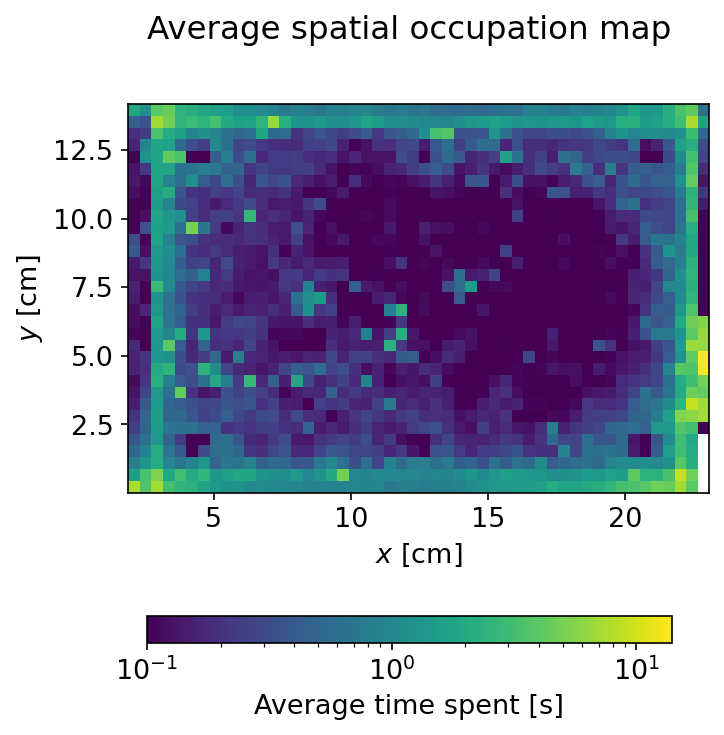

In [6]:
fig, ax = plt.subplots(figsize=(5,4.5))
cmap = plt.get_cmap('viridis')

normData = np.sum(occupationMapArr, axis=0) / len(np.unique([m["dataset"] for m in metadataArr]))
cmapNorm = mpl.colors.LogNorm(vmin=np.nanmin(normData)+1e-1, vmax=np.nanmax(normData))
#cmapNorm = mpl.colors.PowerNorm(gamma=1, vmin=400, vmax=np.nanmax(occupationMapArr))

pcolor = ax.pcolormesh(xBinArr / 10, yBinArr / 10, normData.T , cmap=cmap, norm=cmapNorm, rasterized=True)

ax.set_ylabel('$y$ [cm]')
ax.set_xlabel('$x$ [cm]')

ax.set_aspect(1)

# fig.subplots_adjust(right=0.85)
# cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.03, 0.7, 0.04])

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cmapNorm, cmap=cmap),
                    cax=cbar_ax,
                    label='Average time spent [s]', orientation='horizontal')

fig.suptitle('Average spatial occupation map', y=0.96)
#fig.tight_layout()
#fig.suptitle('Average Spatial Occupation for Ant Simulations', y=0.96)
pltsaveall('03_AllOccupationMap')
plt.show()

## Plot all occupation maps overlaid

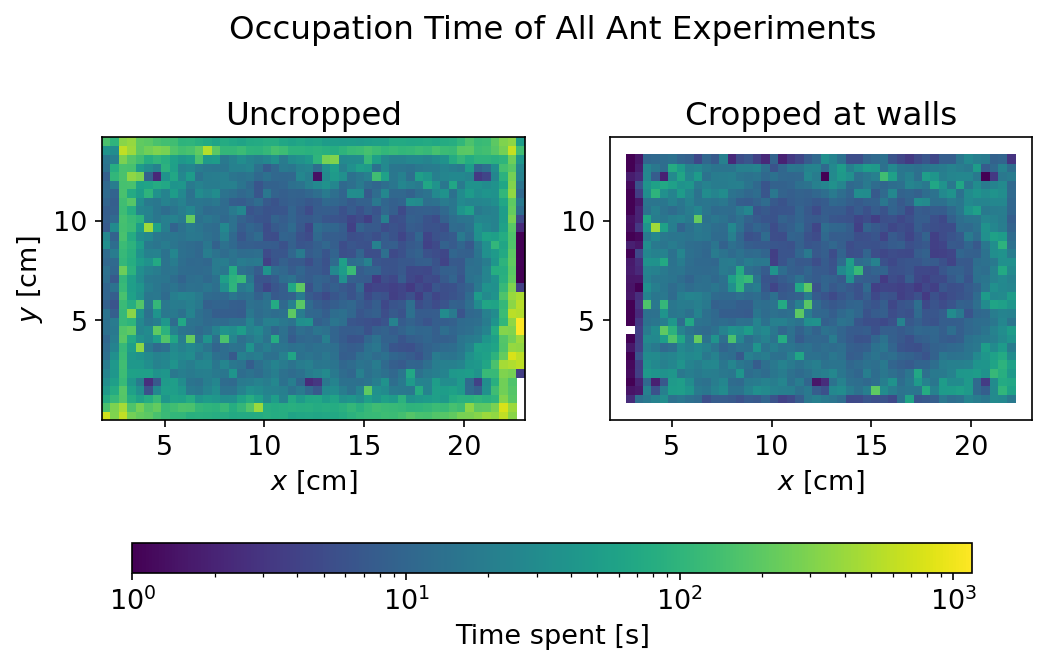

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

cmap = plt.get_cmap('viridis')
cmapNorm = mpl.colors.LogNorm(vmin=np.min(np.sum(occupationMapArr, axis=0))+1, vmax=np.max(np.sum(occupationMapArr, axis=0)))

ax[0].pcolor(xBinArr / 10, yBinArr / 10, np.sum(occupationMapArr, axis=0).T, cmap=cmap, norm=cmapNorm)
ax[1].pcolor(xBinArr / 10, yBinArr / 10, np.sum(noWallOccupationMapArr, axis=0).T, cmap=cmap, norm=cmapNorm)

ax[0].set_ylabel('$y$ [cm]')

ax[0].set_title('Uncropped')
ax[1].set_title('Cropped at walls')

for i in range(2):
    ax[i].set_xlabel('$x$ [cm]')
#    ax[i].set_xlim([xBins[0] / 10, xBins[-1] / 10])
#    ax[i].set_ylim([yBins[0] / 10, yBins[-1] / 10])

    ax[i].set_aspect(1)

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.05, 0.70, 0.05])

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cmapNorm, cmap=cmap), cax=cbar_ax,
             label='Time spent [s]', orientation='horizontal')

fig.suptitle('Occupation Time of All Ant Experiments')
#pltsaveall('03_AllOccupationMapComparison')
plt.show()

## Compute Pearson R

In [41]:
from scipy import stats
rArr = np.zeros((len(uniqueTrials), len(uniqueTrials)))

for i in tqdm(range(len(uniqueTrials))): 
    for j in range(len(uniqueTrials)):
        res = stats.pearsonr(occupationMapArr[i].flatten('C'), occupationMapArr[j].flatten('C'), alternative='two-sided')
        rArr[i,j] = res.statistic

noWallRArr = np.zeros((len(noWallUniqueTrials), len(noWallUniqueTrials)))

for i in tqdm(range(len(noWallUniqueTrials))): 
    for j in range(len(noWallUniqueTrials)):
        res = stats.pearsonr(noWallOccupationMapArr[i].flatten('C'), noWallOccupationMapArr[j].flatten('C'), alternative='two-sided')
        noWallRArr[i,j] = res.statistic


100%|███████████████████████████████████████████| 96/96 [00:07<00:00, 13.06it/s]


## Pearson R with and without walls

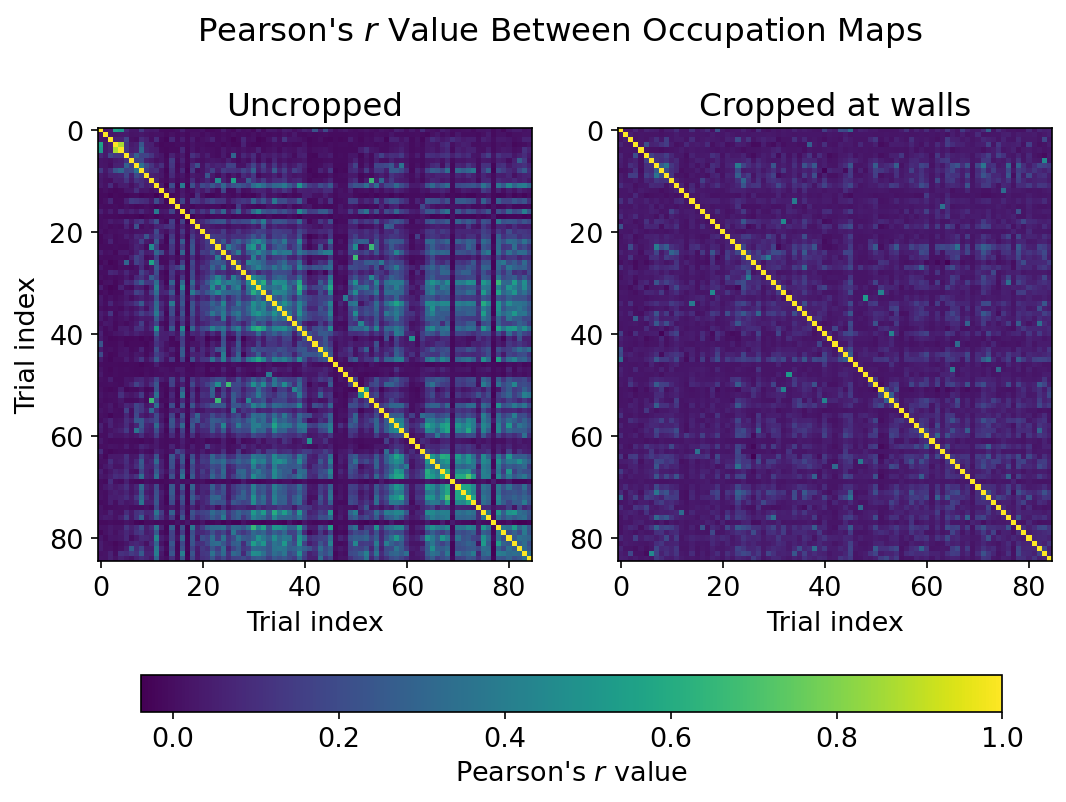

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(8.2,5))

img = ax[0].imshow(rArr)
ax[1].imshow(noWallRArr)

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.16, 0.05, 0.70, 0.05])

fig.colorbar(img, cax=cbar_ax, orientation='horizontal',
            label='Pearson\'s $r$ value')
fig.suptitle(f'Pearson\'s $r$ Value Between Occupation Maps')
#ax.set_title(f'Pearson R Statistic Between Occupation Maps\nWith walls')

for i in range(2):
    ax[i].set_xlabel('Trial index')
ax[0].set_ylabel('Trial index')

ax[0].set_title('Uncropped')
ax[1].set_title('Cropped at walls')
pltsaveall('03_OccupationMapPearsonR_CropComparison')
plt.show()

## Pearson R for cleaned and uncleaned trials

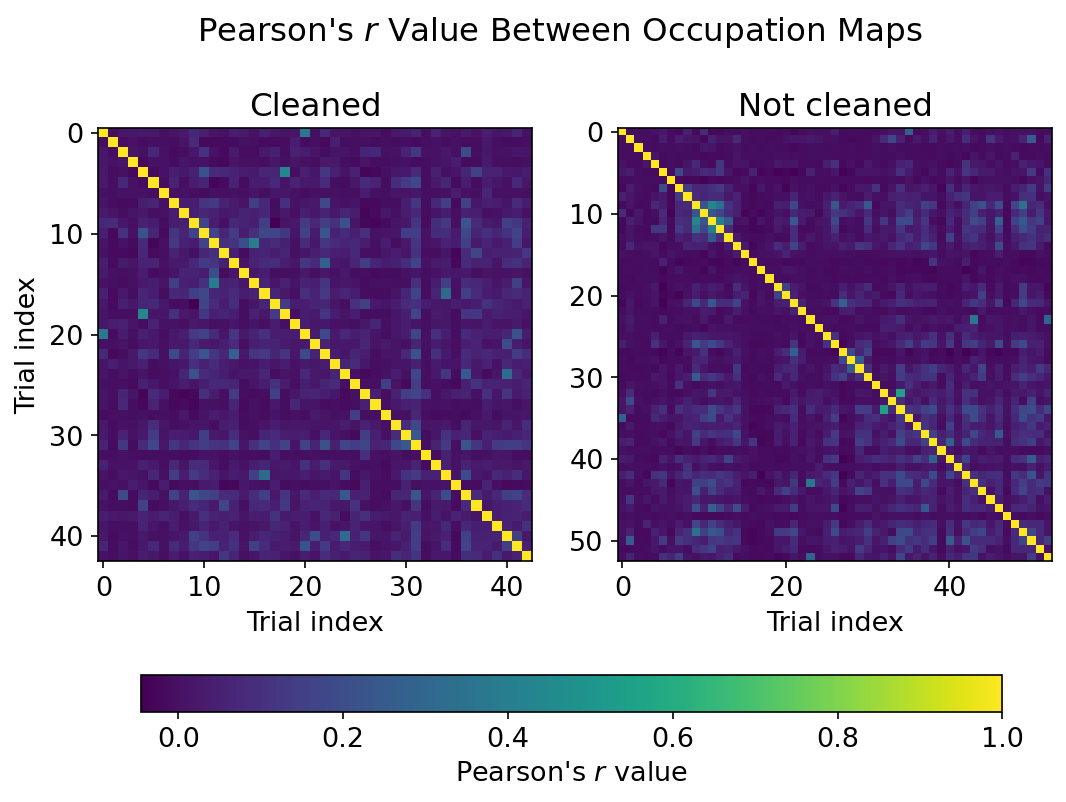

In [42]:
datasetArr = np.array([m["name"] for m in noWallMetadataArr])
exampleIndices = np.array([np.where(datasetArr == trial)[0][0] for trial in noWallUniqueTrials])
# This array is True or False for each trial depending on whether
# the enclosure was cleaned prior to the experiment.
cleanedArr = np.array([noWallMetadataArr[i]["cleaned"] for i in exampleIndices])
objectsArr = np.array([noWallMetadataArr[i]["objects"] == '[]' for i in exampleIndices])

cleanedIndices = np.where(cleanedArr & objectsArr)[0]
uncleanedIndices = np.array([i for i in range(len(noWallOccupationMapArr)) if i not in cleanedIndices and objectsArr[i]])
objectsIndices = np.where(~objectsArr)[0]

# Cleaned vs uncleaned cropped
fig, ax = plt.subplots(1, 2, figsize=(8.2,5))

img = ax[0].imshow(noWallRArr[cleanedIndices,:][:,cleanedIndices])

ax[1].imshow(noWallRArr[uncleanedIndices,:][:,uncleanedIndices])

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.16, 0.05, 0.70, 0.05])

fig.colorbar(img, cax=cbar_ax, orientation='horizontal',
            label='Pearson\'s $r$ value')
fig.suptitle(f'Pearson\'s $r$ Value Between Occupation Maps')
#ax.set_title(f'Pearson R Statistic Between Occupation Maps\nWith walls')

for i in range(2):
    ax[i].set_xlabel('Trial index')
ax[0].set_ylabel('Trial index')

ax[0].set_title('Cleaned')
ax[1].set_title('Not cleaned')
#pltsaveall('03_OccupationMapPearsonR_CleaningComparison')
plt.show()

## Compute how the Pearson R decays through time

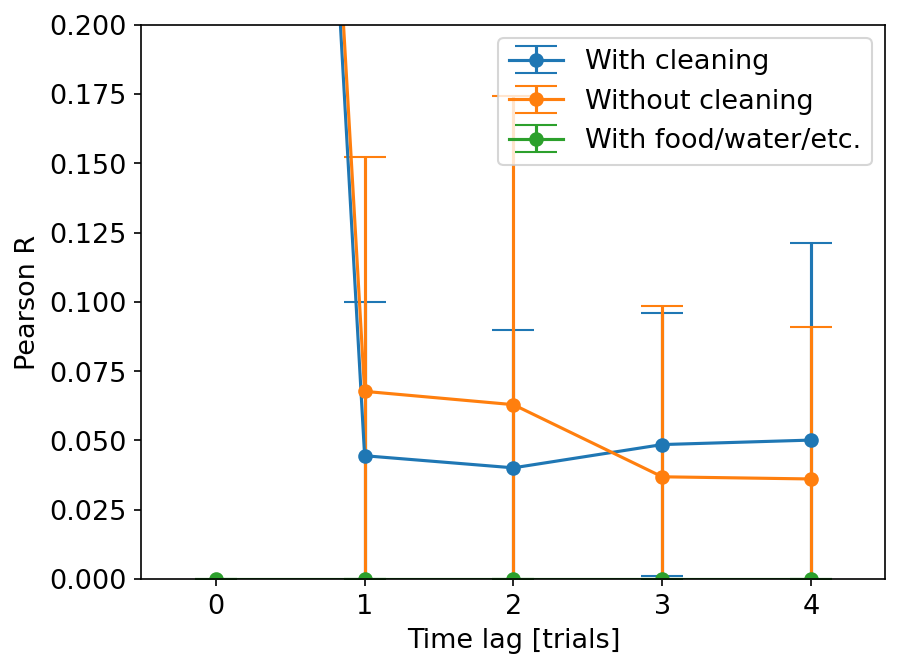

In [43]:
maxLag = 4

cleanedRArr = noWallRArr[cleanedIndices,:][:,cleanedIndices]
uncleanedRArr = noWallRArr[uncleanedIndices,:][:,uncleanedIndices]
objectsRArr = noWallRArr[objectsIndices,:][:,objectsIndices]

cleanedCorrDecayArr = np.zeros(len(cleanedIndices))
cleanedCorrDecaySTDArr = np.zeros(len(cleanedIndices))

uncleanedCorrDecayArr = np.zeros(len(uncleanedIndices))
uncleanedCorrDecaySTDArr = np.zeros(len(uncleanedIndices))

objectsCorrDecayArr = np.zeros(len(uncleanedIndices))
objectsCorrDecaySTDArr = np.zeros(len(uncleanedIndices))

# i indexes over time lag
for i in range(len(cleanedIndices)):
    # Zero out all entries we don't care about, and then turn them to nan so we ignore them
    corrMatrix = cleanedRArr * np.eye(len(cleanedIndices), k=i)
    corrMatrix[corrMatrix == 0] = np.nan
    
    cleanedCorrDecayArr[i] = np.nanmean(corrMatrix)
    cleanedCorrDecaySTDArr[i] = np.nanstd(corrMatrix)# / (len(cleanedIndices) - i)

for i in range(len(uncleanedIndices)):
    corrMatrix = uncleanedRArr * np.eye(len(uncleanedIndices), k=i)
    corrMatrix[corrMatrix == 0] = np.nan

    uncleanedCorrDecayArr[i] = np.nanmean(corrMatrix)
    uncleanedCorrDecaySTDArr[i] = np.nanstd(corrMatrix)# / (len(uncleanedIndices) - i)

for i in range(len(objectsIndices)):
    corrMatrix = objectsRArr * np.eye(len(objectsIndices), k=i)
    corrMatrix[corrMatrix == 0] = np.nan

    objectsCorrDecayArr[i] = np.nanmean(corrMatrix)
    objectsCorrDecaySTDArr[i] = np.nanstd(corrMatrix)# / (len(objectsIndices) - i)

plt.errorbar(np.arange(len(cleanedCorrDecayArr))[:maxLag+1], cleanedCorrDecayArr[:maxLag+1],
             yerr=cleanedCorrDecaySTDArr[:maxLag+1], marker='o', capsize=10, label='With cleaning')

plt.errorbar(np.arange(len(uncleanedCorrDecayArr))[:maxLag+1], uncleanedCorrDecayArr[:maxLag+1],
             yerr=uncleanedCorrDecaySTDArr[:maxLag+1], marker='o', capsize=10, label='Without cleaning')

plt.errorbar(np.arange(len(objectsCorrDecayArr))[:maxLag+1], objectsCorrDecayArr[:maxLag+1],
             yerr=objectsCorrDecaySTDArr[:maxLag+1], marker='o', capsize=10, label='With food/water/etc.')

#plt.yscale('log')
plt.xlabel('Time lag [trials]')
plt.ylabel('Pearson R')
plt.xlim([-0.5, maxLag+0.5])
plt.ylim([0, 0.2])
plt.legend()
plt.show()

## Perform Welch's T-test on mean Pearson R

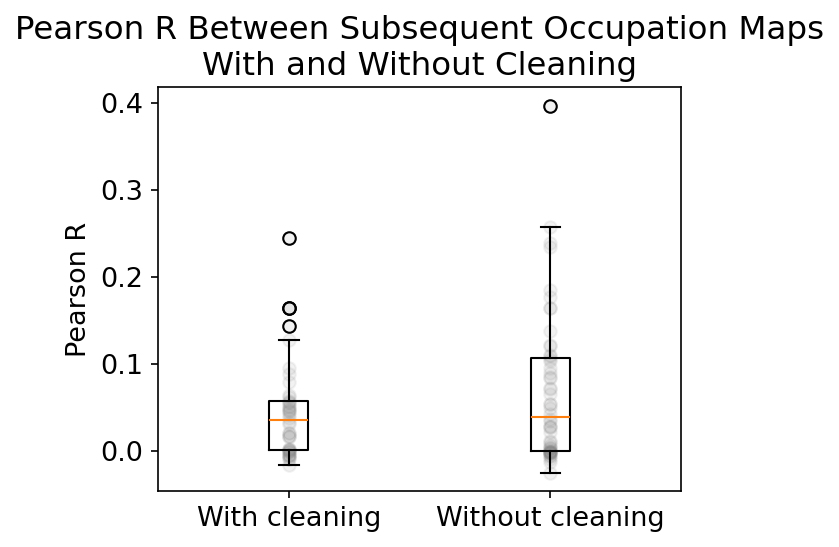

T statistic: -1.5835512672548298
P value: 0.058430725229959846


In [44]:
# We need to use Welch's T-test since the variance of the two
# sets of values is different (see the +/- values above)
N1 = len(cleanedRArr) - 1
N2 = len(uncleanedRArr) - 1

# Grab the elements next to the diagonal 
x = cleanedRArr[np.arange(N1), np.arange(N1)+1]
y = uncleanedRArr[np.arange(N2), np.arange(N2)+1]

plt.scatter(np.zeros(N1)+1, x, alpha=0.1, c='gray')
plt.scatter(np.zeros(N2)+2, y, alpha=0.1, c='gray')

plt.boxplot([x, y], sym='o')
plt.xticks([1, 2], ['With cleaning', 'Without cleaning'])
plt.ylabel('Pearson R')
plt.title('Pearson R Between Subsequent Occupation Maps\nWith and Without Cleaning')
plt.gcf().set_size_inches((4.5,3.5))
plt.show()

# If you take the mean of these x and y you should get the
# statistics printed out above
# 'less' because the alternative hypothesis to these distributions
# being equal is that the correlations for cleaned trials is less
# than that of uncleaned ones
tStat, pVal = stats.ttest_ind(x, y, equal_var=False, alternative='less')
print(f'T statistic: {tStat}')
print(f'P value: {pVal}')

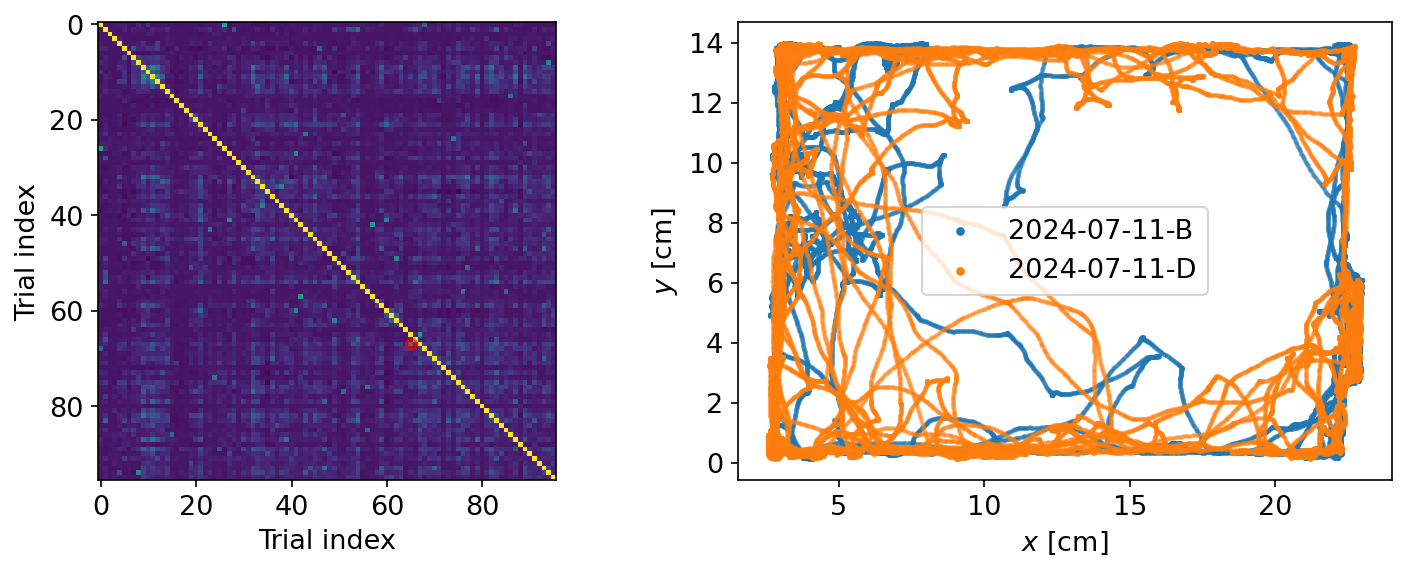

In [201]:
# Compare specific trials
maxIndex = 1
nonDiagRArr = noWallRArr.copy()
nonDiagRArr = nonDiagRArr * (np.ones_like(nonDiagRArr) - np.eye(len(nonDiagRArr)))

sortedIndices = np.argsort(nonDiagRArr, axis=None)[::-1]

raveledIndices = np.array([np.sort(np.unravel_index(i, nonDiagRArr.shape)) for i in sortedIndices])

i,j = raveledIndices[maxIndex*2]

fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].imshow(noWallRArr)
ax[0].scatter(i,j, s=30, c='red', alpha=0.5)
ax[0].set_xlabel('Trial index')
ax[0].set_ylabel('Trial index')

colors = ['tab:blue', 'tab:orange']
segmentTrialIdentity = np.array([indexDict[metadataArr[l]["name"]] for l in range(len(dataArr))])

for ki, k in enumerate([i,j]):
    ax[1].scatter([], [], c=colors[ki], s=10, label=metadataArr[np.where(segmentTrialIdentity == k)[0][0]]["name"])

    for l in np.where(segmentTrialIdentity == k)[0]:
        ax[1].scatter(*dataArr[l].T / 10, c=colors[ki], s=2, alpha=0.3)

ax[1].set_xlabel('$x$ [cm]')
ax[1].set_ylabel('$y$ [cm]')

ax[1].legend()
fig.tight_layout()
plt.show()

# Parameter space maps (position and orientation)

In [7]:
# Compute the orientation of the walker
def computeOrientation(trajectoryArr):
    """
    """
    # We will need the step sizes (in the measured frame)
    # to weight the contributions to the overall run direction
    originalStepDirectionArr = trajectoryArr[1:] - trajectoryArr[:-1]
   
    # Compute the orientation (angle) of the walker at each step.
    absoluteAngleArr = np.arctan2(*(originalStepDirectionArr.T / np.sqrt(np.sum(originalStepDirectionArr**2, axis=-1))))

    # This will have length one less than trajectory arr, so we duplicate the value at the beginning
    # so it can be indexed the same.
    absoluteAngleArr = np.concatenate((absoluteAngleArr[:1], absoluteAngleArr))

    if len(absoluteAngleArr) > 5:
        # Smooth gently
        absoluteAngleArr = savgol_filter(absoluteAngleArr, 5, 1)
    
    return absoluteAngleArr

In [8]:
numSpatialBins = 50
numAngleBins = 20

# Compute the edges of the arena from the trajectories
# (accounting for padding if we have any).
minDataPoints = np.min([np.min(d, axis=0) for d in dataArr if len(d) > 1], axis=0)
maxDataPoints = np.max([np.max(d, axis=0) for d in dataArr if len(d) > 1], axis=0)

scalingFactor = (maxDataPoints - minDataPoints)
scalingFactor /= np.max(scalingFactor)

xBins = np.linspace(minDataPoints[0], maxDataPoints[0], int(scalingFactor[0]*numSpatialBins+1))
yBins = np.linspace(minDataPoints[1], maxDataPoints[1], int(scalingFactor[1]*numSpatialBins+1))
#angleBins = np.linspace(-np.pi, np.pi, numAngleBins+1)
angleBins = np.linspace(-np.pi * (1 + 1/numAngleBins), np.pi * (1 - 1/numAngleBins), numAngleBins+1)

# The midpoints of the bins that we will use to plot
xBinArr = (xBins[1:] + xBins[:-1]) / 2
yBinArr = (yBins[1:] + yBins[:-1]) / 2
angleBinArr = (angleBins[1:] + angleBins[:-1]) / 2

uniqueTrials = np.unique([m["name"] for m in metadataArr])
occupationMapArr = np.zeros((len(uniqueTrials),
                             int(scalingFactor[0]*numSpatialBins),
                             int(scalingFactor[1]*numSpatialBins),
                             numAngleBins))

indexDict = dict(zip(uniqueTrials, np.arange(len(uniqueTrials))))

noWallUniqueTrials = np.unique([m["name"] for m in noWallMetadataArr])
noWallOccupationMapArr = np.zeros((len(noWallUniqueTrials),
                                   int(scalingFactor[0]*numSpatialBins),
                                   int(scalingFactor[1]*numSpatialBins),
                                   numAngleBins))

noWallIndexDict = dict(zip(noWallUniqueTrials, np.arange(len(noWallUniqueTrials))))

for i in tqdm(range(len(dataArr))):
    if len(dataArr[i]) <= 1:
        continue
        
    angles = computeOrientation(dataArr[i])
    parameterSpaceArr = np.zeros((len(dataArr[i]), 3))
    parameterSpaceArr[:,:2] = dataArr[i]
    parameterSpaceArr[:,-1] = angles
    
    hist, bins = np.histogramdd(parameterSpaceArr, bins=[xBins, yBins, angleBins])
    occupationMapArr[indexDict[metadataArr[i]["name"]]] += hist / metadataArr[i]["fps"]

for i in tqdm(range(len(noWallDataArr))):
    if len(noWallDataArr[i]) <= 1:
        continue

    angles = computeOrientation(noWallDataArr[i])
    parameterSpaceArr = np.zeros((len(noWallDataArr[i]), 3))
    parameterSpaceArr[:,:2] = noWallDataArr[i]
    parameterSpaceArr[:,-1] = angles

    hist, bins = np.histogramdd(parameterSpaceArr, bins=[xBins, yBins, angleBins])
    noWallOccupationMapArr[noWallIndexDict[noWallMetadataArr[i]["name"]]] += hist / noWallMetadataArr[i]["fps"]

  1%|▌                                       | 17/1254 [00:00<00:07, 164.70it/s]/tmp/ipykernel_87706/2625513920.py:10: RuntimeWarning: invalid value encountered in divide
  absoluteAngleArr = np.arctan2(*(originalStepDirectionArr.T / np.sqrt(np.sum(originalStepDirectionArr**2, axis=-1))))
100%|█████████████████████████████████████| 2625/2625 [00:01<00:00, 2382.16it/s]


## Plot a selection of orientations

/tmp/ipykernel_87706/609605121.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


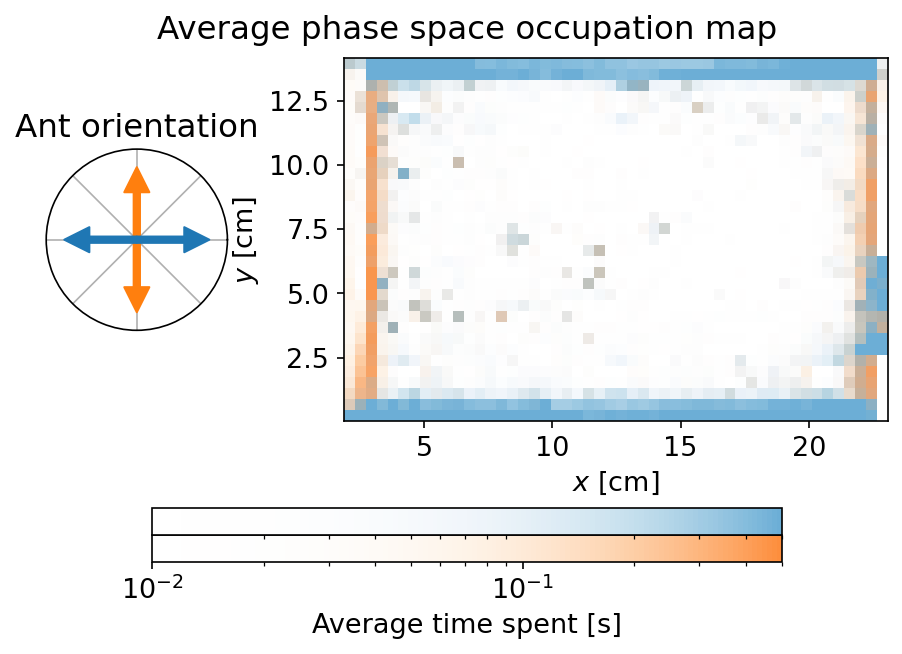

In [9]:
testAngleIndices = [10, 5]
colors = ['tab:blue', 'tab:orange'][::-1]
colorMaps = ['Blues', 'Oranges'][::-1]

fig = plt.figure()
gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[1,3])

radialAx = fig.add_subplot(gs[0], projection='polar')
ax = fig.add_subplot(gs[1])
fig.subplots_adjust(bottom=0.35)

for i in range(len(testAngleIndices)):
    angleIndex = testAngleIndices[i]
    symmetricIndex = (testAngleIndices[i] + len(angleBinArr)//2) % len(angleBinArr)
    
    #radialAx.arrow(0, 0, np.cos(angleBinArr[angleIndex]), np.sin(angleBinArr[angleIndex]), width=0.1)
    radialAx.set_title('Ant orientation')
    radialAx.annotate("", xytext=(0.5, 0.5), xy=(0.5 + 0.4 * np.sin(angleBinArr[angleIndex]), 0.5 + 0.4 * np.cos(angleBinArr[angleIndex])),
                      arrowprops={"width": 3, "color": colors[i]}, xycoords='axes fraction')
    
    radialAx.annotate("", xytext=(0.5, 0.5), xy=(0.5 + 0.4 * np.sin(angleBinArr[symmetricIndex]), 0.5 + 0.4 * np.cos(angleBinArr[symmetricIndex])),
                      arrowprops={"width": 3, "color": colors[i]}, xycoords='axes fraction')
    
    radialAx.set_rticks([])
    radialAx.set_xticks(radialAx.get_xticks(), labels=['']*8)
    
    # Choose colormap
    cmap = plt.get_cmap(colorMaps[i])
    
    # Get the colormap colors
    my_cmap = cmap(np.arange(cmap.N))[:cmap.N//2]
    
    # Set alpha
    my_cmap[:,-1] = np.linspace(0, 1, cmap.N//2)**2
    #my_cmap[:,-1] = 0.1
    
    # Create new colormap
    my_cmap = mpl.colors.ListedColormap(my_cmap)

    normData = (np.sum(occupationMapArr[:,:,:,angleIndex], axis=0) + np.sum(occupationMapArr[:,:,:,symmetricIndex], axis=0)) / len(np.unique([m["dataset"] for m in metadataArr]))
    # Chosen manually to be constant
    cmapNorm = mpl.colors.LogNorm(vmin=10**(-2),
                                  vmax=10**(-0.3))
    # cmapNorm = mpl.colors.LogNorm(vmin=np.nanmin(normData)+1/metadataArr[0]["fps"],
    #                               vmax=np.nanmax(normData))
    
    #cmapNorm = mpl.colors.PowerNorm(gamma=1, vmin=400, vmax=np.nanmax(occupationMapArr))
    
    pcolor = ax.pcolormesh(xBinArr / 10, yBinArr / 10, normData.T, cmap=my_cmap, norm=cmapNorm, rasterized=True)
    
    ax.set_ylabel('$y$ [cm]')
    ax.set_xlabel('$x$ [cm]')
    
    ax.set_aspect(1)
    
    cbar_ax = fig.add_axes([0.15, 0.02 + 0.04*i, 0.70, 0.04])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cmapNorm, cmap=my_cmap),
                        cax=cbar_ax,
                        orientation='horizontal')

    if i == 0:
        cbar.set_label('Average time spent [s]')
    else:
        cbar.set_ticks([])
        
#fig.suptitle('Average Phase Space Occupation for Ant Experiments', y=0.83)
fig.set_size_inches((6,4.5))
fig.suptitle('Average phase space occupation map', y=0.83)
fig.tight_layout()
pltsaveall(f'03_AllParameterSpaceMap')
plt.show()

## Compute Pearson's R

In [14]:
from scipy import stats
rArr = np.zeros((len(uniqueTrials), len(uniqueTrials)))

for i in tqdm(range(len(uniqueTrials))): 
    for j in range(len(uniqueTrials)):
        res = stats.pearsonr(occupationMapArr[i].flatten('C'), occupationMapArr[j].flatten('C'), alternative='two-sided')
        rArr[i,j] = res.statistic

noWallRArr = np.zeros((len(noWallUniqueTrials), len(noWallUniqueTrials)))

for i in tqdm(range(len(noWallUniqueTrials))): 
    for j in range(len(noWallUniqueTrials)):
        res = stats.pearsonr(noWallOccupationMapArr[i].flatten('C'), noWallOccupationMapArr[j].flatten('C'), alternative='two-sided')
        noWallRArr[i,j] = res.statistic


100%|███████████████████████████████████████████| 85/85 [00:09<00:00,  9.23it/s]


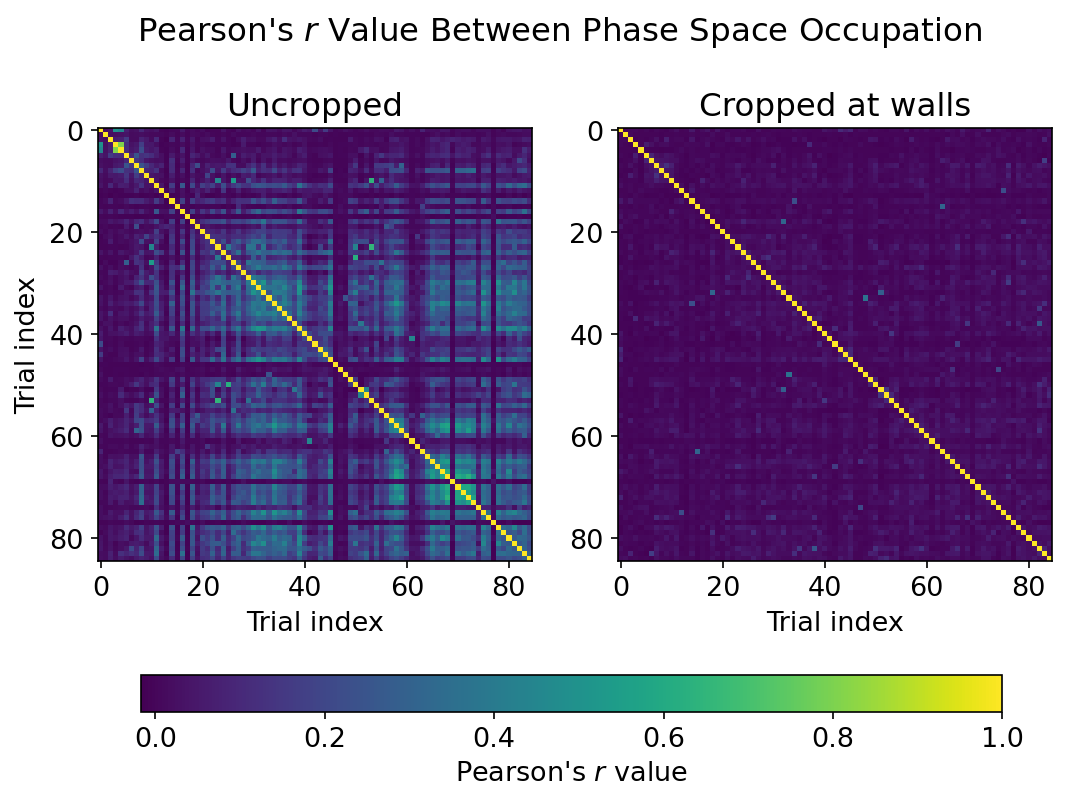

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(8.2,5))

img = ax[0].imshow(rArr)
ax[1].imshow(noWallRArr)

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.16, 0.05, 0.70, 0.05])

fig.colorbar(img, cax=cbar_ax, orientation='horizontal',
            label='Pearson\'s $r$ value')
fig.suptitle(f'Pearson\'s $r$ Value Between Phase Space Occupation')
#ax.set_title(f'Pearson R Statistic Between Occupation Maps\nWith walls')

for i in range(2):
    ax[i].set_xlabel('Trial index')
ax[0].set_ylabel('Trial index')

ax[0].set_title('Uncropped')
ax[1].set_title('Cropped at walls')
pltsaveall('03_PhaseSpaceMapPearsonR_CropComparison')

plt.show()

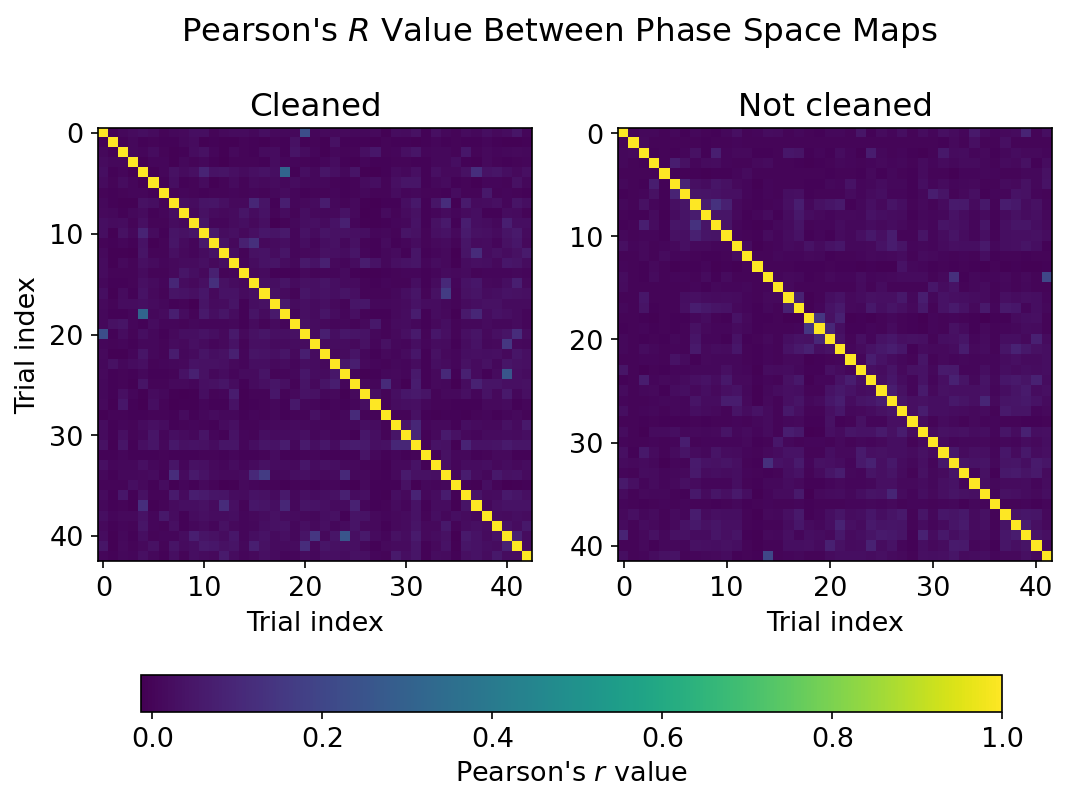

In [20]:
datasetArr = np.array([m["name"] for m in noWallMetadataArr])
exampleIndices = np.array([np.where(datasetArr == trial)[0][0] for trial in noWallUniqueTrials])

# This array is True or False for each trial depending on whether
# the enclosure was cleaned prior to the experiment.
cleanedArr = np.array([noWallMetadataArr[i]["cleaned"] for i in exampleIndices])
objectsArr = np.array([noWallMetadataArr[i]["objects"] == '[]' for i in exampleIndices])

cleanedIndices = np.where(cleanedArr & objectsArr)[0]
uncleanedIndices = np.array([i for i in range(len(noWallOccupationMapArr)) if i not in cleanedIndices])# and objectsArr[i]])
objectsIndices = np.where(~objectsArr)[0]

# Cleaned vs uncleaned cropped
fig, ax = plt.subplots(1, 2, figsize=(8.2,5))

#norm = mpl.colors.LogNorm()

img = ax[0].imshow(noWallRArr[cleanedIndices,:][:,cleanedIndices])#, norm=norm)
ax[1].imshow(noWallRArr[uncleanedIndices,:][:,uncleanedIndices])#, norm=norm)

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.16, 0.05, 0.70, 0.05])

fig.colorbar(img, cax=cbar_ax, orientation='horizontal',
            label='Pearson\'s $r$ value')
fig.suptitle(f'Pearson\'s $R$ Value Between Phase Space Maps')
#ax.set_title(f'Pearson R Statistic Between Occupation Maps\nWith walls')

for i in range(2):
    ax[i].set_xlabel('Trial index')
ax[0].set_ylabel('Trial index')

ax[0].set_title('Cleaned')
ax[1].set_title('Not cleaned')
pltsaveall('03_PhaseSpaceMapPearsonR_CleaningComparison')
plt.show()

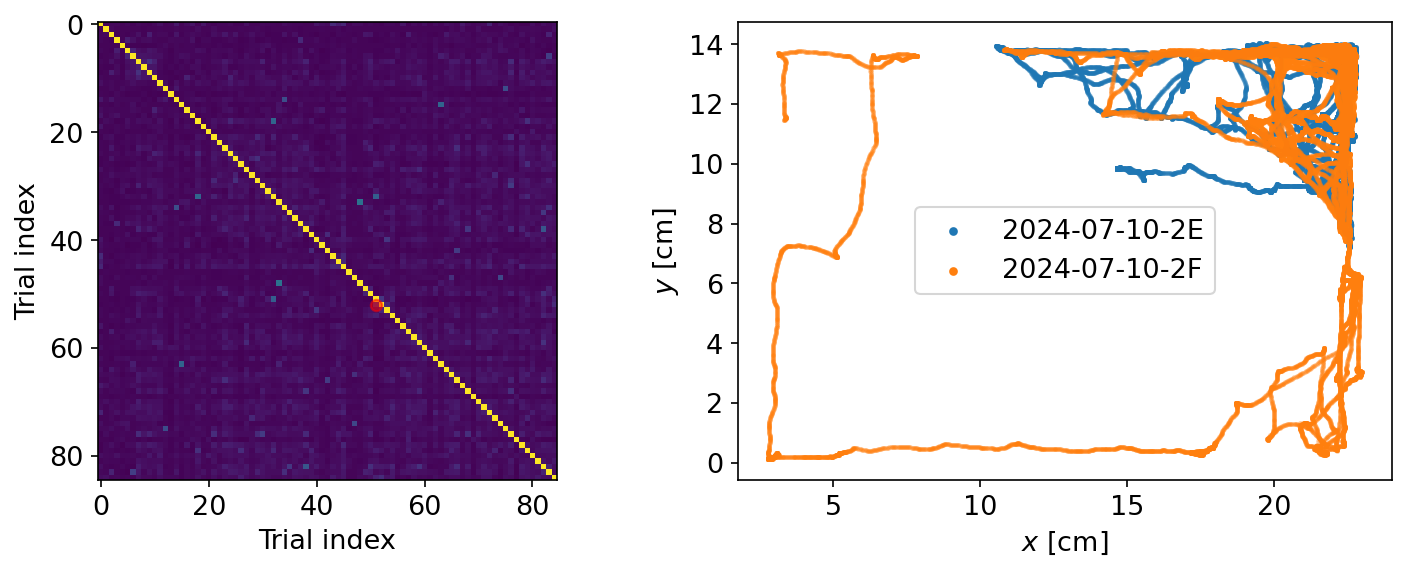

In [36]:
# Compare specific trials
maxIndex = 13
nonDiagRArr = noWallRArr.copy()
nonDiagRArr = nonDiagRArr * (np.ones_like(nonDiagRArr) - np.eye(len(nonDiagRArr)))

sortedIndices = np.argsort(nonDiagRArr, axis=None)[::-1]

raveledIndices = np.array([np.sort(np.unravel_index(i, nonDiagRArr.shape)) for i in sortedIndices])

i,j = raveledIndices[maxIndex*2]

fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].imshow(noWallRArr)
ax[0].scatter(i,j, s=30, c='red', alpha=0.5)
ax[0].set_xlabel('Trial index')
ax[0].set_ylabel('Trial index')

colors = ['tab:blue', 'tab:orange']
segmentTrialIdentity = np.array([indexDict[metadataArr[l]["name"]] for l in range(len(dataArr))])

for ki, k in enumerate([i,j]):
    ax[1].scatter([], [], c=colors[ki], s=10, label=metadataArr[np.where(segmentTrialIdentity == k)[0][0]]["name"])

    for l in np.where(segmentTrialIdentity == k)[0]:
        ax[1].scatter(*dataArr[l].T / 10, c=colors[ki], s=2, alpha=0.3)

ax[1].set_xlabel('$x$ [cm]')
ax[1].set_ylabel('$y$ [cm]')

ax[1].legend()
fig.tight_layout()
plt.show()

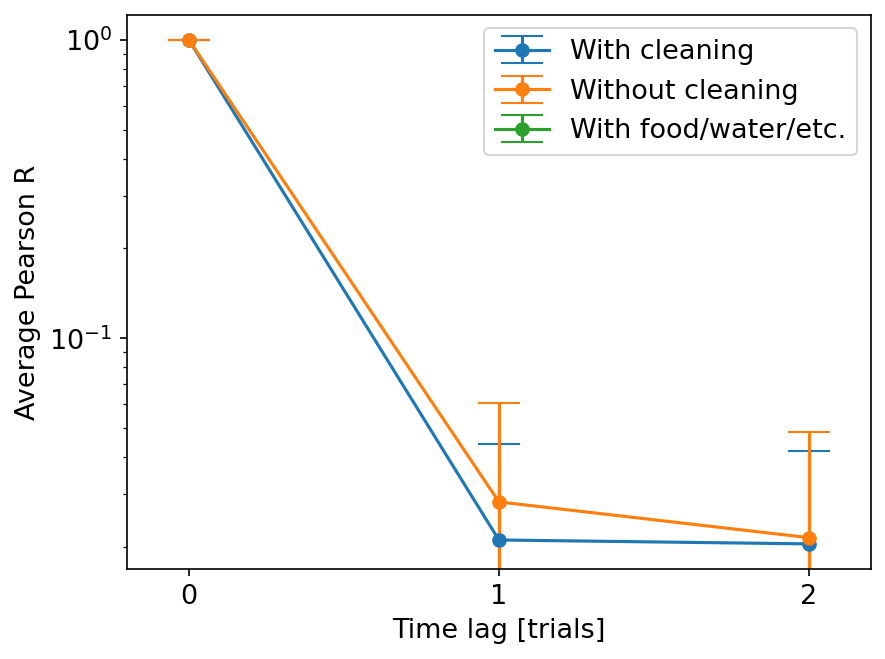

Mean Pearson R for subsequent trials
Without cleaning: 0.028269789729262966 +/- 0.03248546793184543
With cleaning: 0.021073265913327355  +/- 0.022969625934161426


In [21]:
maxLag = 2

cleanedRArr = noWallRArr[cleanedIndices,:][:,cleanedIndices]
uncleanedRArr = noWallRArr[uncleanedIndices,:][:,uncleanedIndices]
objectsRArr = noWallRArr[objectsIndices,:][:,objectsIndices]

cleanedCorrDecayArr = np.zeros(len(cleanedIndices))
cleanedCorrDecaySTDArr = np.zeros(len(cleanedIndices))

uncleanedCorrDecayArr = np.zeros(len(uncleanedIndices))
uncleanedCorrDecaySTDArr = np.zeros(len(uncleanedIndices))

objectsCorrDecayArr = np.zeros(len(uncleanedIndices))
objectsCorrDecaySTDArr = np.zeros(len(uncleanedIndices))

# i indexes over time lag
for i in range(len(cleanedIndices)):
    # Zero out all entries we don't care about, and then turn them to nan so we ignore them
    corrMatrix = cleanedRArr * np.eye(len(cleanedIndices), k=i)
    corrMatrix[corrMatrix == 0] = np.nan
    
    cleanedCorrDecayArr[i] = np.nanmean(corrMatrix)
    cleanedCorrDecaySTDArr[i] = np.nanstd(corrMatrix)# / (len(cleanedIndices) - i)

for i in range(len(uncleanedIndices)):
    corrMatrix = uncleanedRArr * np.eye(len(uncleanedIndices), k=i)
    corrMatrix[corrMatrix == 0] = np.nan

    uncleanedCorrDecayArr[i] = np.nanmean(corrMatrix)
    uncleanedCorrDecaySTDArr[i] = np.nanstd(corrMatrix)# / (len(uncleanedIndices) - i)

for i in range(len(objectsIndices)):
    corrMatrix = objectsRArr * np.eye(len(objectsIndices), k=i)
    corrMatrix[corrMatrix == 0] = np.nan

    objectsCorrDecayArr[i] = np.nanmean(corrMatrix)
    objectsCorrDecaySTDArr[i] = np.nanstd(corrMatrix)# / (len(objectsIndices) - i)

plt.errorbar(np.arange(len(cleanedCorrDecayArr))[:maxLag+1], cleanedCorrDecayArr[:maxLag+1],
             yerr=cleanedCorrDecaySTDArr[:maxLag+1], marker='o', capsize=10, label='With cleaning')

plt.errorbar(np.arange(len(uncleanedCorrDecayArr))[:maxLag+1], uncleanedCorrDecayArr[:maxLag+1],
             yerr=uncleanedCorrDecaySTDArr[:maxLag+1], marker='o', capsize=10, label='Without cleaning')

plt.errorbar(np.arange(len(objectsCorrDecayArr))[:maxLag+1], objectsCorrDecayArr[:maxLag+1],
             yerr=objectsCorrDecaySTDArr[:maxLag+1], marker='o', capsize=10, label='With food/water/etc.')

plt.yscale('log')
plt.xlabel('Time lag [trials]')
plt.ylabel('Average Pearson R')
plt.xlim([-0.2, maxLag+0.2])
plt.xticks(np.arange(maxLag+1))
#plt.ylim([0, 0.2])
plt.legend()
plt.show()

print('Mean Pearson R for subsequent trials')
print(f'Without cleaning: {uncleanedCorrDecayArr[1]} +/- {uncleanedCorrDecaySTDArr[1]}')
print(f'With cleaning: {cleanedCorrDecayArr[1]}  +/- {cleanedCorrDecaySTDArr[1]}')

## Perform Welch's T-test on mean Pearson R

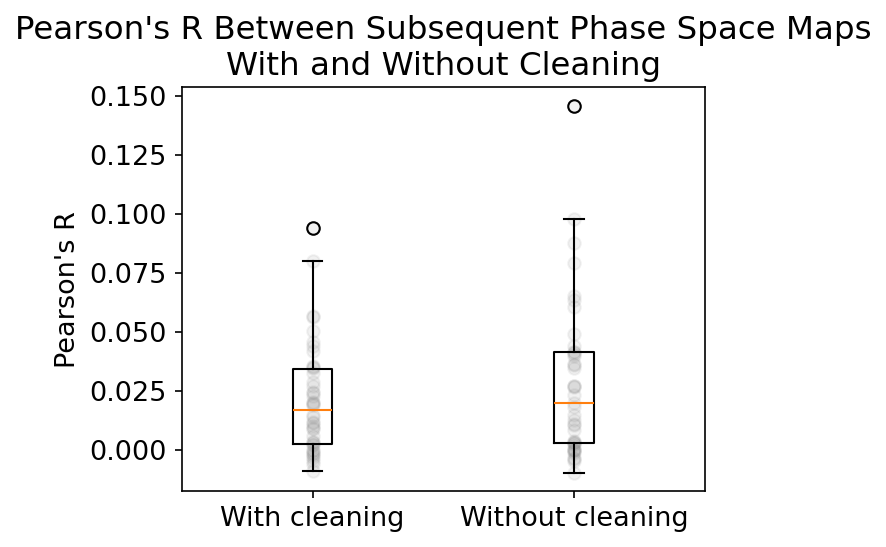

T statistic: -1.14867527072161
P value: 0.1272496159697794


In [22]:
# We need to use Welch's T-test since the variance of the two
# sets of values is different (see the +/- values above)
N1 = len(cleanedRArr) - 1
N2 = len(uncleanedRArr) - 1

# Grab the elements next to the diagonal 
x = cleanedRArr[np.arange(N1), np.arange(N1)+1]
y = uncleanedRArr[np.arange(N2), np.arange(N2)+1]

plt.scatter(np.zeros(N1)+1, x, alpha=0.1, c='gray')
plt.scatter(np.zeros(N2)+2, y, alpha=0.1, c='gray')

plt.boxplot([x, y], sym='o')
plt.xticks([1, 2], ['With cleaning', 'Without cleaning'])
plt.ylabel('Pearson\'s R')
plt.title('Pearson\'s R Between Subsequent Phase Space Maps\nWith and Without Cleaning')
plt.gcf().set_size_inches((4.5,3.5))
plt.show()

# If you take the mean of these x and y you should get the
# statistics printed out above
# 'less' because the alternative hypothesis to these distributions
# being equal is that the correlations for cleaned trials is less
# than that of uncleaned ones
tStat, pVal = stats.ttest_ind(x, y, equal_var=False, alternative='less')
print(f'T statistic: {tStat}')
print(f'P value: {pVal}')